# The NASA Exoplanet Archive

This database uses the TAP protocol to query a range of tables (examples of fetching data can be found in `fetch_data.py`).

Below, we will fetch from the Planetary Systems database [10.26133/NEA12]

In [1]:
# Import the packages needed for this project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from sklearn.metrics import confusion_matrix, classification_report
from scipy.signal import savgol_filter
from scipy.fft import rfft, rfftfreq

# Define some global constants
plt.rcParams["figure.figsize"] = (12.8, 7.2) # for a 1280x720 display
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.titlesize"] = 16 
plt.rcParams["legend.fontsize"] = 10 
plt.rcParams["legend.title_fontsize"] = 14
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["lines.markersize"] = 6
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.3

## Part 1:

Recreate some plots given on the archive website. `Plots_Exercise` includes the process of each one.

The main goal here is to explore the underlying relationships between planetary properties, and the distributions of their features. 

Here are the plots I would like to recreate:
1. Exolanet mass vs. orbital period
2. Cumulative exoplanet discovery frequency by year
3. Eccentricity vs. orbital period
4. Planet density vs. planet radius

### Significance of plotting by discovery method

Each method of discovery is sensitive to different properties, like size, orbital period and mass etc. 

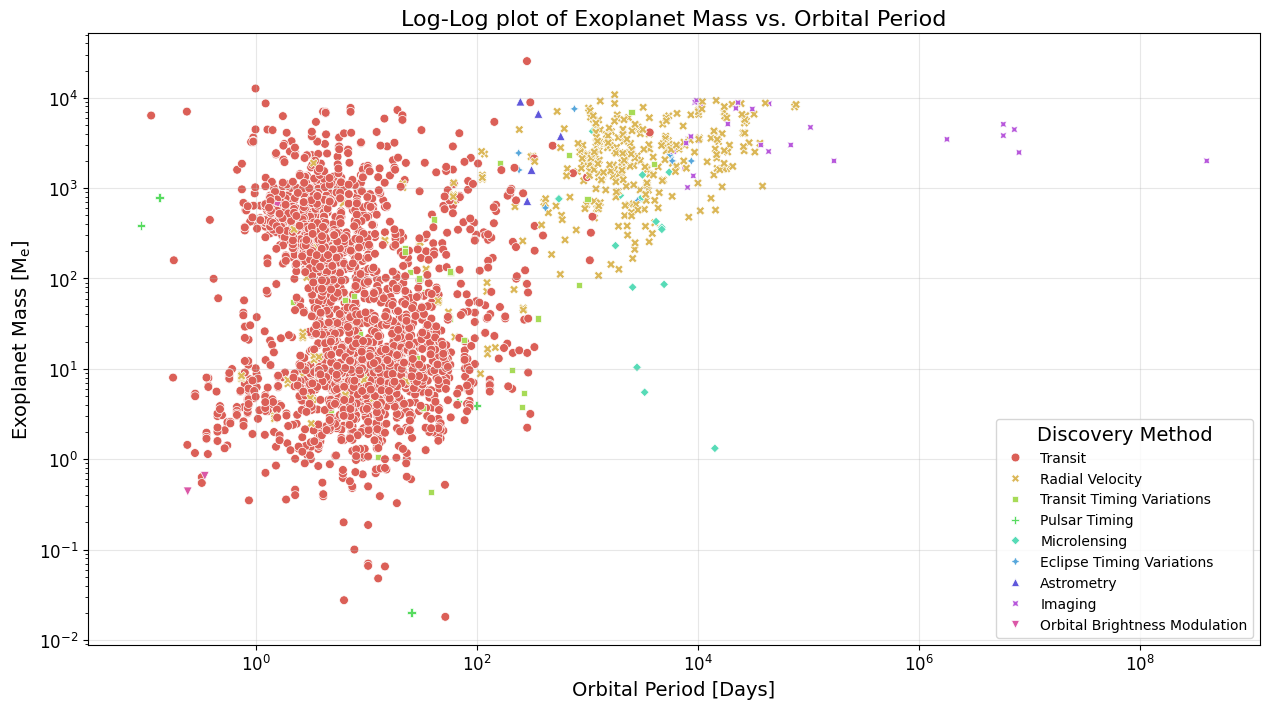

In [2]:
# Plot 1:
df = pd.read_csv("Plots_Exercise/plots_data.csv")
df = df[["pl_orbper", "pl_masse", "discoverymethod"]]
df.dropna(inplace=True)

methods = df["discoverymethod"].unique()

fig, ax = plt.subplots()
sns.scatterplot(
    data=df, 
    x="pl_orbper", 
    y="pl_masse", 
    hue="discoverymethod", 
    style="discoverymethod",
    palette=sns.hls_palette(len(methods)), 
    ax=ax,
    s=40
)

ax.set_xscale("log")
ax.set_yscale("log")

ax.legend(title="Discovery Method")
plt.title("Log-Log plot of Exoplanet Mass vs. Orbital Period")
ax.set_xlabel("Orbital Period [Days]")
ax.set_ylabel(r"Exoplanet Mass [$\text{M}_\text{e}$]")
plt.tight_layout()
plt.show()

### Summary of plot 1:

We see a clear disparity of method over orbital period, however the planetary mass is not as indicative of the method used to discover the exoplanet.

Refer to ***/Exercise_1/Plot_1.ipynb*** for more detail, and a stacked histogram of each method over orbital period.

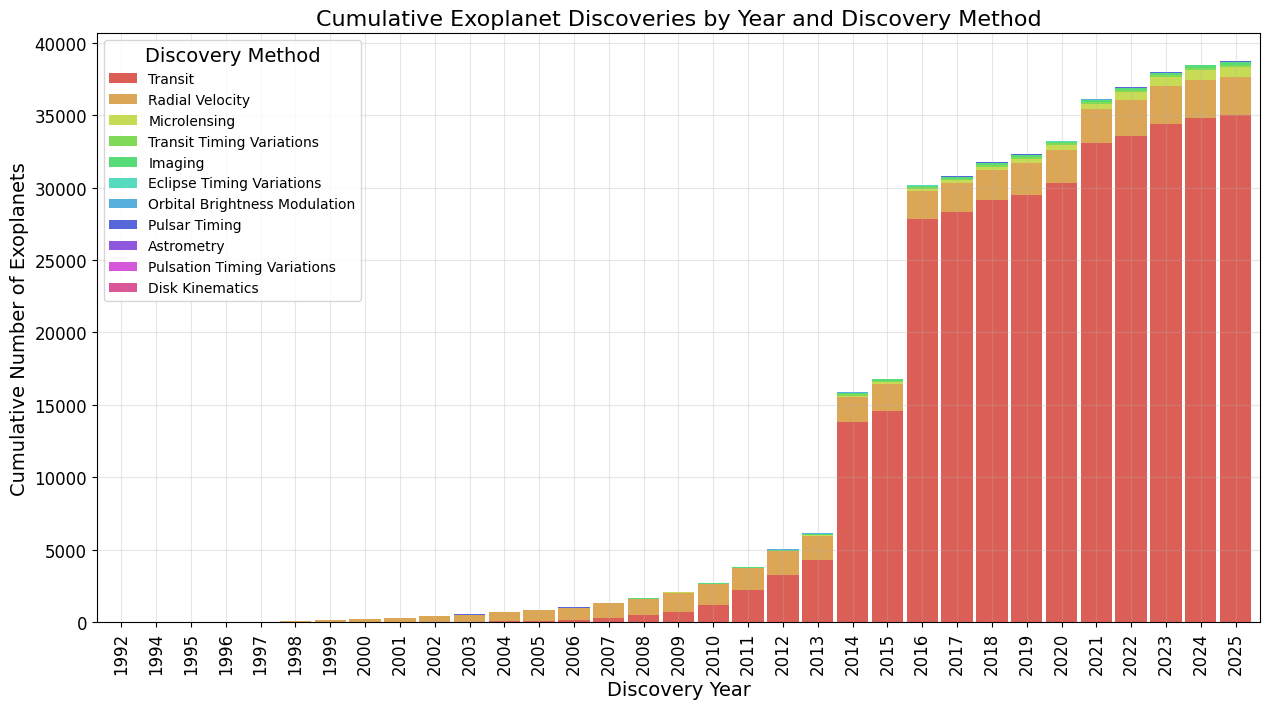

In [3]:
# Plot 2:
df = pd.read_csv("Plots_Exercise/plots_data.csv")
df = df[["disc_year", "discoverymethod"]]
df.dropna(inplace=True)

year_method_counts = df.groupby(['disc_year', 'discoverymethod']).size().unstack(fill_value=0)

cumulative_counts = year_method_counts.cumsum()

method_order = cumulative_counts.iloc[-1].sort_values(ascending=False).index
cumulative_counts = cumulative_counts[method_order]

hsl_palette = sns.color_palette("hls", len(cumulative_counts.columns))

cumulative_counts.plot(
    kind="bar",
    stacked=True,
    color=hsl_palette,
    width=0.9,
    edgecolor="none"
)

plt.title("Cumulative Exoplanet Discoveries by Year and Discovery Method")
plt.xlabel("Discovery Year")
plt.ylabel("Cumulative Number of Exoplanets")
plt.legend(title="Discovery Method")
plt.tight_layout()
plt.show()

### Summary of plot 2:

Interestingly, the number of cumulative discoveries through radial velocity (orange) seems to remain constant, if not slowly rising, through the years. Discoveries through transit is the most dominant through time, seeing significant spikes in 2014 and 2016.

Both can be explained by the release of Kepler's mission results, 

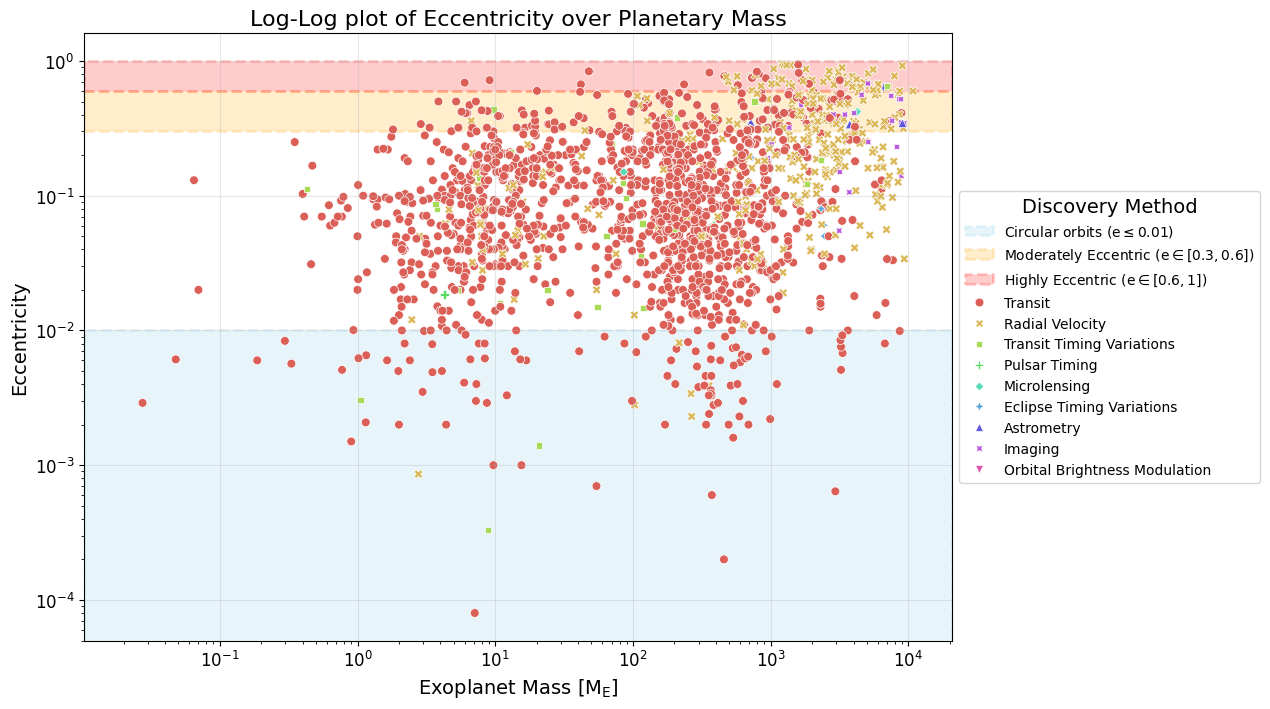

In [4]:
# Plot 3:
df = pd.read_csv("Plots_Exercise/plots_data.csv")
df = df[["pl_masse", "pl_orbeccen", "discoverymethod"]].dropna()

methods = df["discoverymethod"].unique()

# a band for "circular" orbits
plt.axhspan(0.0, 0.01, color="skyblue", linestyle="--", linewidth=2, 
    label=r"Circular orbits (e$\leq 0.01$)", alpha=0.2)

# the moderate-high eccentricity bands
plt.axhspan(0.3, 0.6, color="orange", linestyle="--", linewidth=2, 
    label=r"Moderately Eccentric (e$\in [0.3, 0.6]$)", alpha=0.2)
plt.axhspan(0.6, 1.0, color="red", linestyle="--", linewidth=2, 
    label=r"Highly Eccentric (e$\in [0.6,1]$)", alpha=0.2)

sns.scatterplot(
    data=df, 
    x="pl_masse", 
    y="pl_orbeccen", 
    hue="discoverymethod", 
    style="discoverymethod",
    palette=sns.hls_palette(len(methods)), 
    s=40
)

plt.xscale("log")
plt.yscale("log")

plt.legend(title="Discovery Method", loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title("Log-Log plot of Eccentricity over Planetary Mass")
plt.xlabel(r"Exoplanet Mass [M$_\text{E}$]")
plt.ylabel("Eccentricity")
plt.tight_layout()
plt.show()

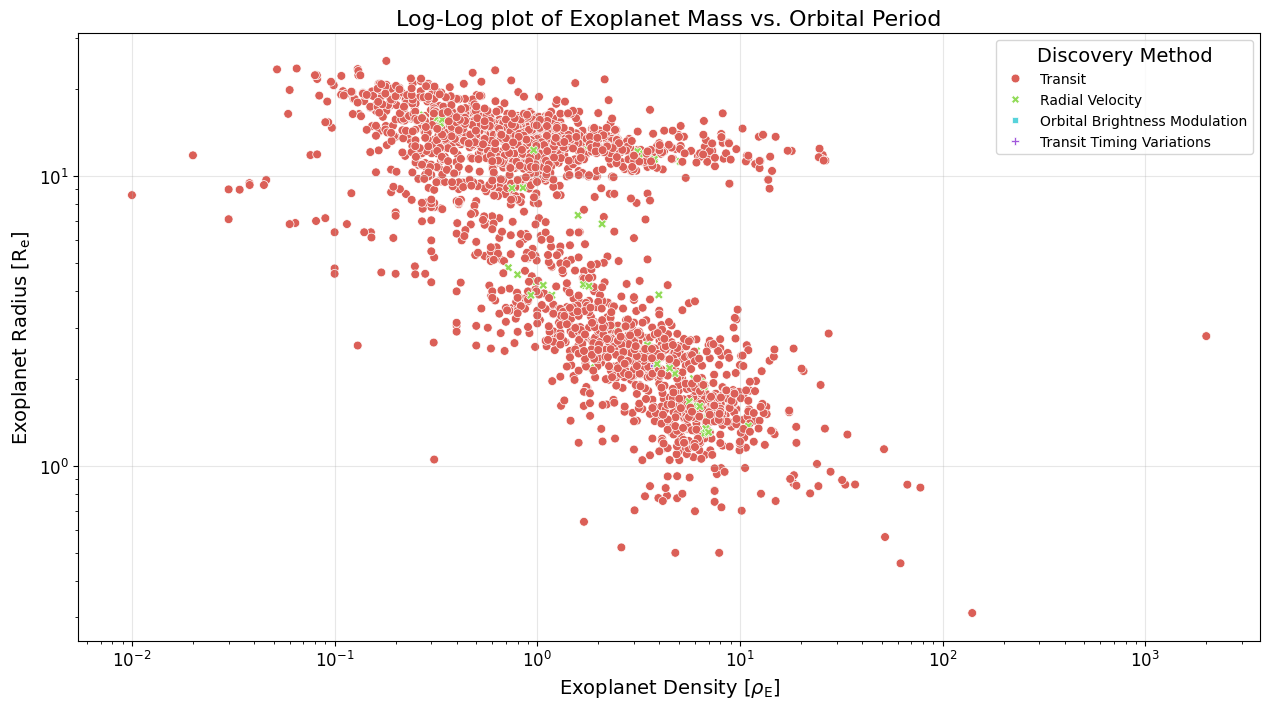

In [5]:
# Plot 4:
df = pd.read_csv("Plots_Exercise/plots_data.csv")
df = df[["pl_dens", "pl_rade", "discoverymethod"]]
df.dropna(inplace=True)

methods = df["discoverymethod"].unique()

fig, ax = plt.subplots()
sns.scatterplot(
    data=df, 
    x="pl_dens", 
    y="pl_rade", 
    hue="discoverymethod", 
    style="discoverymethod",
    palette=sns.hls_palette(len(methods)), 
    ax=ax,
    s=40
)

ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(title="Discovery Method")
plt.title("Log-Log plot of Exoplanet Mass vs. Orbital Period")
ax.set_xlabel(r"Exoplanet Density [$\rho_\text{E}$]")
ax.set_ylabel(r"Exoplanet Radius [$\text{R}_\text{e}$]")
plt.tight_layout()
plt.show()

## Part 2:

Kepler Objects of Interest table (KOI) `/Kepler_Candidates`

- Focussed on 21 numerical features
- Trained a RandomForestCLassifier to achieve a true positive accuracy of $99.3\%$

In [6]:
# insert relevant code + plots from the koi section.
# currently incomplete since I havent run the nn yet

## Part 3:

Exoplanet Detection. The [dataset](https://www.kaggle.com/datasets/keplersmachines/kepler-labelled-time-series-data) is sourced from Kaggle, and contains labelled light curves for nearly 6000 exoplanet candidates.

The dataset comes pre-split into train/test in `/exoData` (which is in .gitignore, saving storage space)

Each row in the data is structured the same:
1. Column 1: "LABEL", where `1 => no exoplanet`, and `2 => Exoplanet`
2. Columns $j\in [2,3198]$: "FLUX.($j-1$)", flux readings at the $j-1$th timestep. Plotting these values on a line graph gives the lightcurve of the stellar host that flagged an exoplanet candidate.

The `/exoData/exoTrain.csv` contains:
- 5087 samples (lightcurves)
- 37 positives (confirmed exoplanet stars)

The `/exoData/exoTest.csv` contains:
- 570 samples
- 5 positives

### Criticisms of the data

Both the training and testing data are **extremely imbalanced**. The issue with this is models are not encouraged to extract meaningful features and gain insight on the data, but only to guess on the majority class. If you are to give this dataset to a simple model that guesses wrong (no exoplanet star), that model would still have an accuracy of $99.1\%$.

This poses significant issue when trying to train models, there are only 37 positives to learn from, making generalisation a challenge.

### Addressing mitigations

Firstly, intead of taking accuracy as the primary performance metric, it will be smart to also consider **recall** and **ROC-AUC**.

In [27]:
LCs = pd.read_csv("Exoplanet_Detection/exoData/exoTrain.csv")
LCs["LABEL"] = LCs["LABEL"].map({2:1, 1:0}) # 1 => exoplanet, 0 => no exoplanet

def preprocess(X): # Preprocessing pipeline, derived in 'FT_lightcurves'

    X = X.sub(X.mean(axis=1), axis=0).div(X.std(axis=1), axis=0).fillna(0)
    X = np.abs(rfft(X, axis=1))
    X = savgol_filter(X, window_length=13, polyorder=3, axis=1)

    return X

LCs

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,1,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,1,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,1,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,1,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,1,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5082,0,-91.91,-92.97,-78.76,-97.33,-68.00,-68.24,-75.48,-49.25,-30.92,...,139.95,147.26,156.95,155.64,156.36,151.75,-24.45,-17.00,3.23,19.28
5083,0,989.75,891.01,908.53,851.83,755.11,615.78,595.77,458.87,492.84,...,-26.50,-4.84,-76.30,-37.84,-153.83,-136.16,38.03,100.28,-45.64,35.58
5084,0,273.39,278.00,261.73,236.99,280.73,264.90,252.92,254.88,237.60,...,-26.82,-53.89,-48.71,30.99,15.96,-3.47,65.73,88.42,79.07,79.43
5085,0,3.82,2.09,-3.29,-2.88,1.66,-0.75,3.85,-0.03,3.28,...,10.86,-3.23,-5.10,-4.61,-9.82,-1.50,-4.65,-14.55,-6.41,-2.55


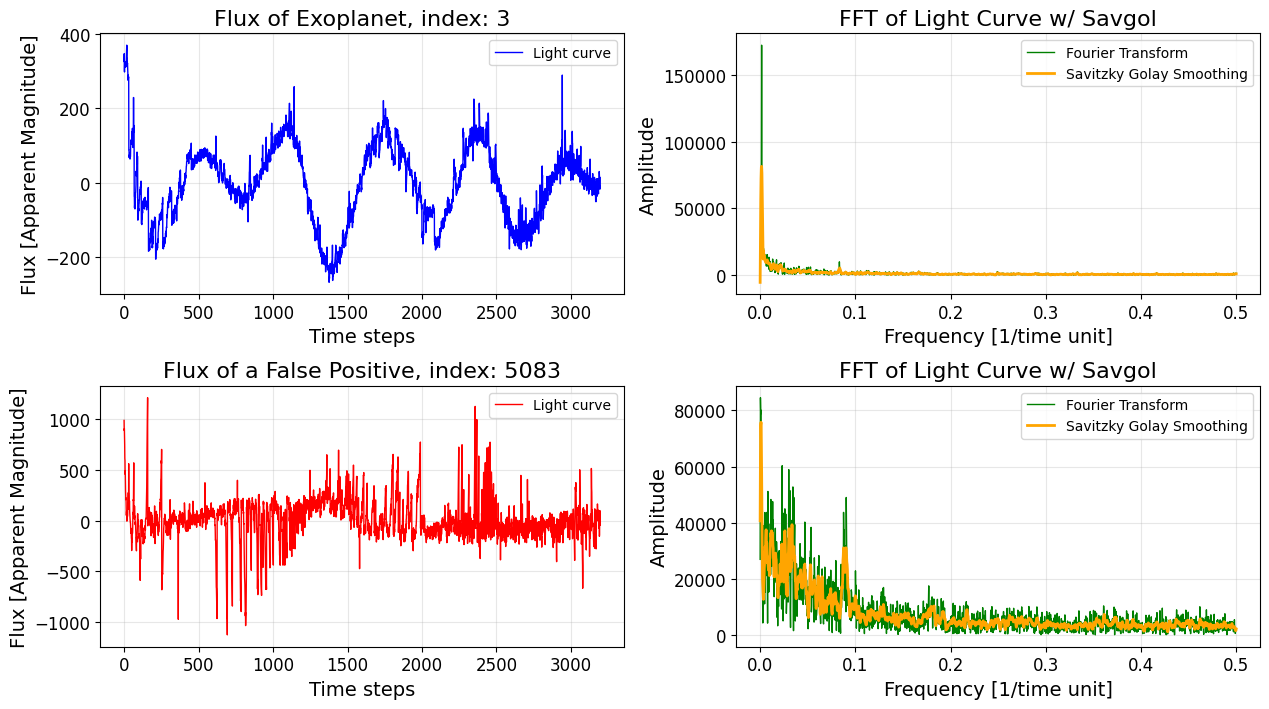

In [28]:
def plot_example_fft(df, idx_false_pos, idx_exoplanet):

    flux_0 = df.iloc[idx_exoplanet].drop(["LABEL"])
    flux_1 = df.iloc[idx_false_pos].drop(["LABEL"])

    N = len(flux_0)

    time = np.arange(N)

    freqs_0 = rfftfreq(len(flux_0))
    freqs_1 = rfftfreq(len(flux_1))
    amps_0 = np.abs(rfft(flux_0))
    amps_1 = np.abs(rfft(flux_1))

    amps_0_smooth = savgol_filter(amps_0, window_length=11, polyorder=3)
    amps_1_smooth = savgol_filter(amps_1, window_length=11, polyorder=3)

    fig, ax = plt.subplots(2, 2)

    ax[0,0].plot(time, flux_0, linewidth=1, c="b", label="Light curve")
    ax[0,0].set_title(f"Flux of Exoplanet, index: {idx_exoplanet}")
    ax[0,0].set_ylabel("Flux [Apparent Magnitude]")
    ax[0,0].set_xlabel("Time steps")

    ax[1,0].plot(time, flux_1, linewidth=1, c="r", label="Light curve")
    ax[1,0].set_title(f"Flux of a False Positive, index: {idx_false_pos}")
    ax[1,0].set_ylabel("Flux [Apparent Magnitude]")
    ax[1,0].set_xlabel("Time steps")

    ax[0,1].plot(freqs_0, amps_0, linewidth=1, c="g", label="Fourier Transform")
    ax[0,1].plot(freqs_0, amps_0_smooth, c="orange", label="Savitzky Golay Smoothing")
    ax[0,1].set_title("FFT of Light Curve w/ Savgol")
    ax[0,1].set_xlabel("Frequency [1/time unit]")
    ax[0,1].set_ylabel("Amplitude")

    ax[1,1].plot(freqs_1, amps_1, linewidth=1, c="g", label="Fourier Transform")
    ax[1,1].plot(freqs_1, amps_1_smooth, c="orange", label="Savitzky Golay Smoothing")
    ax[1,1].set_title("FFT of Light Curve w/ Savgol")
    ax[1,1].set_xlabel("Frequency [1/time unit]")
    ax[1,1].set_ylabel("Amplitude")

    for axis in ax.ravel():
        axis.legend()

    plt.tight_layout()
    plt.show()

plot_example_fft(LCs, 5086-3, 3)

In [31]:
class ExoCNN(nn.Module):
    def __init__(self, input_length):
        super(ExoCNN, self).__init__()

        # 1d convolutions
        self.conv1 = nn.Conv1d(1, 16, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, padding=1)

        # max pooling
        self.pool = nn.MaxPool1d(kernel_size=2)

        fc_input = (input_length // 8) * 64     # 3 layers of pool size 2 -> divide by 2^3 = 8
        self.fc1 = nn.Linear(fc_input, 128)
        self.fc2 = nn.Linear(128, 1)            # binary classification

        # ReU activation
        self.relu = nn.ReLU()

    def forward(self, x):
        # x.shape: [batch_size, 1, input_length]
        
        # 1d conv layer 1
        x = self.conv1(x)   # [batch_size, 16, input_length]
        x = self.relu(x)
        x = self.pool(x)    # input_length -> input_length//2

        # 1d conv layer 2
        x = self.conv2(x)   # [batch_size, 32, input_length//2]
        x = self.relu(x)
        x = self.pool(x)    # input_length//2 -> input_length//4

        # 1d conv layer 3
        x = self.conv3(x)   # [batch_size, 64, input_length//4]
        x = self.relu(x)
        x = self.pool(x)    # input_length//4 -> input_length//8

        # flatten for linear transformations:
        # reshapes from [batch_size, 64, input_length//8]...
        x = x.view(x.size(0), -1) # -> [batch_size, 64 * input_length//8]

        # 2 affine linear transformations
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x # <- pure logits, we handle class imbalance later
    
def prepare_data(filepath):
    data = pd.read_csv(filepath)

    # split X, y
    X = data.drop(["LABEL"], axis=1)
    y = data["LABEL"].map({2:1,1:0}) # relabel

    # preprocess X with existing pipeline
    X = preprocess(X)

    return X, y

class LC_dataset(Dataset):
    def __init__(self, X, y):
        self.X = X.astype("float32")
        self.y = y.astype("float32")

    def __len__(self): # Input length
        return len(self.X)
    
    def __getitem__(self, idx):
        x = torch.from_numpy(self.X[idx]).unsqueeze(0)
        label = torch.tensor([self.y[idx]], dtype=torch.float32)
        return x, label
    
train_ds = LC_dataset(*prepare_data("Exoplanet_Detection/exoData/exoTrain.csv"))
test_ds = LC_dataset(*prepare_data("Exoplanet_Detection/exoData/exoTest.csv"))

batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

L = train_ds[0][0].shape[-1]
print(f"input_length L = {L}")

input_length L = 1599


In [ ]:
# Seed for reproducibility
torch.manual_seed(156) # <- Alfa Romeo 156 GTAs are fantastic cars

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

n = 10 # no. epochs
cnn = ExoCNN(L).to(device)

loss_fn = nn.BCEWithLogitsLoss() # <- applies a sigmoid over the raw logits
optimiser = optim.Adam(cnn.parameters(), lr=0.001)

for epoch in range(n):

    running_loss = 0.0
    cnn.train() # initialise training

    for batch_idx, (inputs, labels) in enumerate(train_dl):

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimiser.zero_grad()
        outputs = cnn(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimiser.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_dl)
    print(f"Epoch [{epoch+1}/{n}] - Loss: {avg_loss:.4f}")

Device: cpu
Epoch [1/10] - Loss: 0.1910
Epoch [2/10] - Loss: 0.0385
Epoch [3/10] - Loss: 0.0268
Epoch [4/10] - Loss: 0.0214
Epoch [5/10] - Loss: 0.0109
Epoch [6/10] - Loss: 0.0088
Epoch [7/10] - Loss: 0.0096
Epoch [8/10] - Loss: 0.0053
Epoch [9/10] - Loss: 0.0029
Epoch [10/10] - Loss: 0.0036


In [52]:
cnn.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_dl:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = cnn(inputs)

        # need to make a decision
        preds = (outputs >= 0.5).int()
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# flatten into single arrays
all_preds = np.vstack(all_preds).flatten()
all_labels = np.vstack(all_labels).flatten()

print(confusion_matrix(all_labels, all_preds))
print("\n========================================================\n")
print(classification_report(all_labels, all_preds, digits=3))

[[564   1]
 [  2   3]]


              precision    recall  f1-score   support

         0.0      0.996     0.998     0.997       565
         1.0      0.750     0.600     0.667         5

    accuracy                          0.995       570
   macro avg      0.873     0.799     0.832       570
weighted avg      0.994     0.995     0.994       570

